The following is an image processing technique used to track and determine characteristics of cell movement. 

### Setup the Project:

In [1]:
from __future__ import division, unicode_literals, print_function
import os.path
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc("figure", figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np 
import pandas as pd
from pandas import DataFrame, Series

In [3]:
import pims
import trackpy as tp
import collections

### Read data and convert to grayscale

In [1]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]

video_path = '/mnt/c/Users/kingf/Desktop/videoalgea/14-x2-2.avi'


if os.path.exists(video_path):
    frames = gray(pims.Video(video_path))
    print('Video loaded successfully!')
else: 
    print('Video fild not found:', video_path)
    

NameError: name 'pims' is not defined

In [9]:
frames

AttributeError: 'av.video.codeccontext.VideoCodecContext' object has no attribute 'long_name'

#### Show the first frame

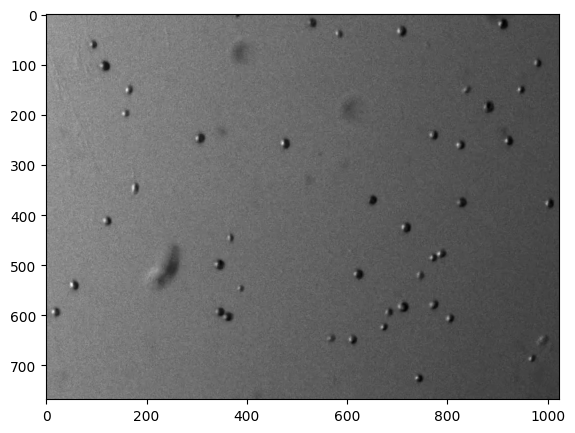

In [10]:
plt.imshow(frames[0]);

### Locate cells

In [11]:
f = tp.locate(frames[0], 17, invert=True)

In [12]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,9.400134,294.589812,374.225425,4.946971,0.087178,8.527925,26836.0,-0.144410,0
1,5.816910,610.563891,394.541953,5.031307,0.232464,8.778747,31675.0,-0.576300,0
2,7.425573,689.559160,262.860754,5.028355,0.389042,7.524640,32595.0,-1.335894,0
3,12.319463,862.905369,373.723782,4.369433,0.233374,6.521355,34536.0,0.750164,0
4,7.486157,571.466224,452.983322,5.003210,0.266651,9.280389,31440.0,-0.503213,0


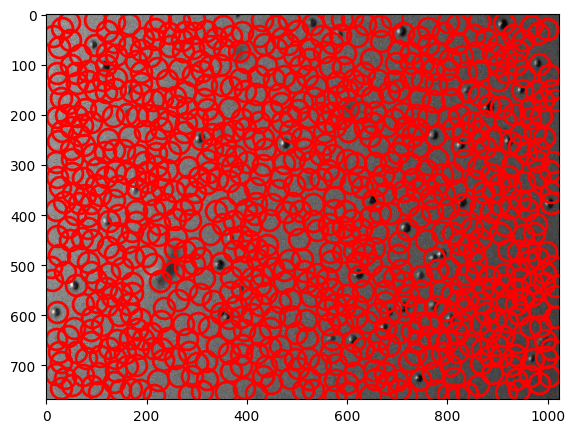

In [13]:
tp.annotate(f, frames[0]);

### Filter data

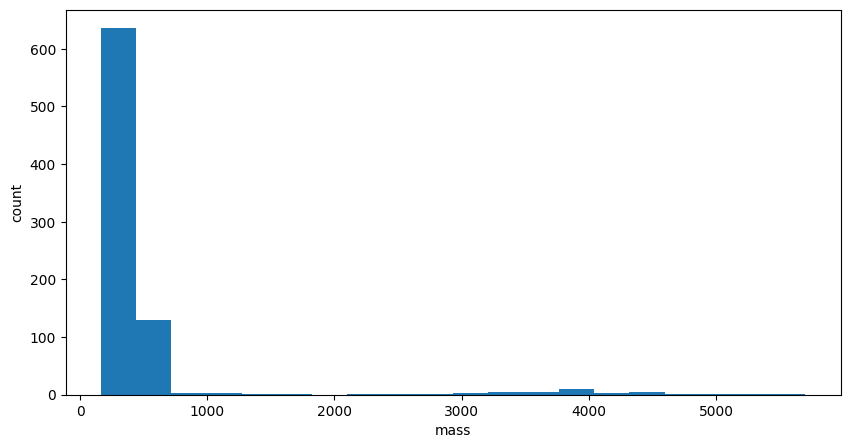

In [14]:
# show the mass(darkness intensity) which includes noise
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

ax.set(xlabel='mass', ylabel='count');

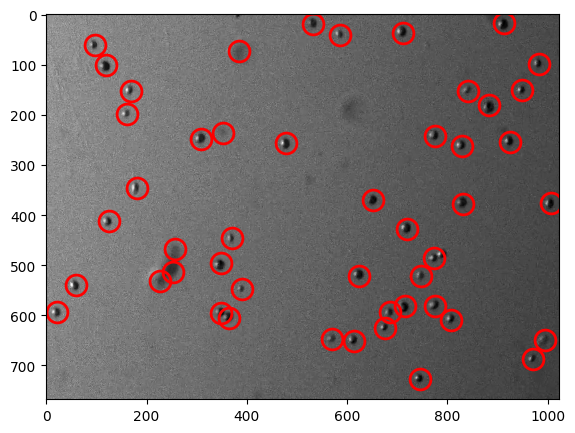

In [15]:
# Set the minmass parameter based on the prior data
f = tp.locate(frames[0], 17, invert=True, minmass=1000)
tp.annotate(f, frames[0]);

### Check for Subpixel Accuracy 

/home/fenix/.local/lib/python3.10/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

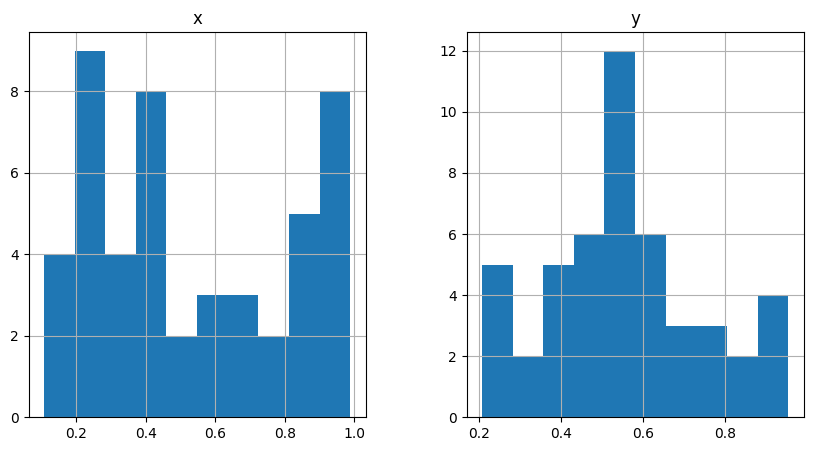

In [16]:
tp.subpx_bias(f)

/home/fenix/.local/lib/python3.10/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


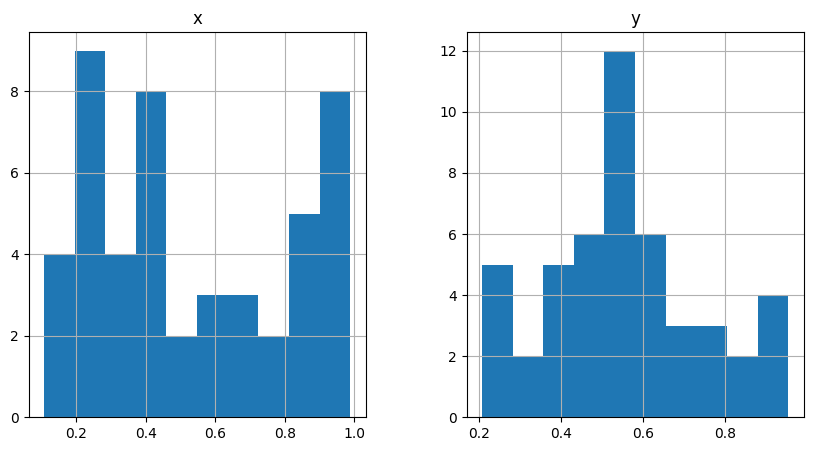

In [17]:
tp.subpx_bias(tp.locate(frames[0], 17, invert=True, minmass=1000));

### Collect data from set of frames into a table

In [18]:
f = tp.batch(frames[:150], 17, minmass=1000, invert=True,processes=1);

Frame 148: 46 features


### Link located cells into particle trajectories

In [19]:
t = tp.link(f, 10, memory=3)

Frame 148: 92 trajectories present.


In [20]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,17.400392,912.518292,3969.749194,5.059225,0.249587,37.623200,44741.0,0.081451,0,0
69,376.576207,1005.871733,3666.506206,4.701138,0.287885,42.137983,43252.0,0.093629,0,1
68,370.266862,652.196719,4373.320715,5.186104,0.132722,36.118272,44673.0,0.081938,0,2
67,345.368460,180.386006,4688.853948,4.560284,0.395930,63.959439,32062.0,-0.757477,0,3
66,262.522927,828.951922,3719.680328,4.631797,0.337994,47.405231,41147.0,0.118723,0,4


### Filter Trajectories

#### Keep only the trajectories that last a certain number of frames (here we test 10 frames)

In [21]:
t1 = tp.filter_stubs(t, 10)

#### Compare the # of trajectories before and after filtering

In [22]:
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 406
After: 156


#### Can also filter by particles' appearance

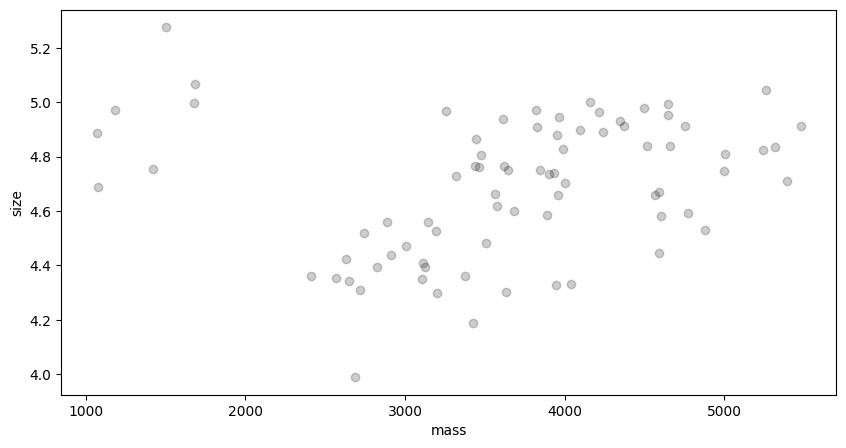

In [23]:
# Plot mass vs. size of particles
plt.figure()
tp.mass_size(t1.groupby('particle').mean());

#### Now apply the filter based on the mass, size, and eccentricity

In [31]:
t2 = t1[((t1['mass'] > 1000) & (t1['size'] < 9) & (t1['ecc'] < 3))]

### Plot the filtered trajectories

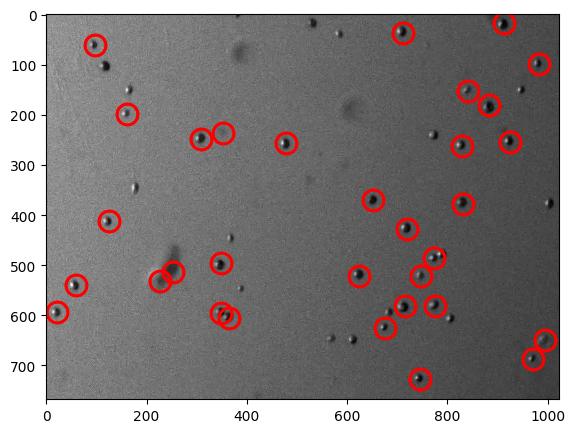

<Axes: >

In [32]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0])

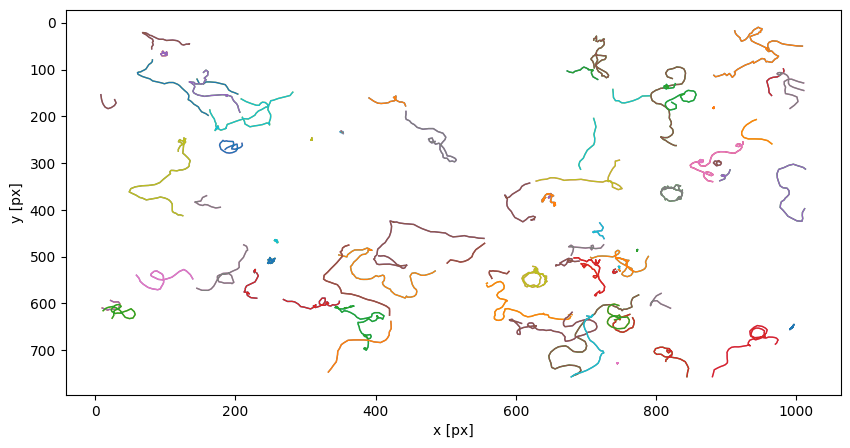

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [33]:
plt.figure()
tp.plot_traj(t2)

In [39]:
# Save the final tracking data
t2.to_excel('TrajectoryData.xlsx', index=True)

## Find Average Cell Position Every Third Frame

In [40]:
t3=t2.copy()

In [41]:
df = 3
t3['x_ave'] = (t3['x'] + t3.groupby('particle')['x'].shift(1) + t3.groupby('particle')['x'].shift(2)) / df
t3['y_ave'] = (t3['y'] + t3.groupby('particle')['y'].shift(1) + t3.groupby('particle')['y'].shift(2)) / df
t4 = t3[(t3['frame']+1) % 3 == 0]
t5 = (t4[['frame', 'particle', 'x_ave', 'y_ave']])
print(t5)

       frame  particle       x_ave       y_ave
frame                                         
2          2         5         NaN         NaN
2          2         6         NaN         NaN
2          2         4         NaN         NaN
2          2        10         NaN         NaN
2          2        51         NaN         NaN
...      ...       ...         ...         ...
146      146        45  773.419379  485.066537
146      146        91  247.768862  510.559516
146      146       344  227.483766  528.781545
146      146       256  744.267775  531.272500
146      146       327  713.072577  540.625567

[1986 rows x 4 columns]


In [42]:
t5.to_excel('AveragePosition.xlsx', index=False)

## Find Velocity (pixels/second) & Angle

#### Here we have 30 frames/second and we took the average position of three frames therefore dt = 1/30 * 3 = 0.1second

In [43]:
t6 = t5.copy()

In [44]:
dt= 0.1
t6['dx']=t6['x_ave'] - t6.groupby('particle')['x_ave'].shift(1)
t6['dy']=t6['y_ave'] - t6.groupby('particle')['y_ave'].shift(1)
t6['velocity'] = ((t6['dx'] ** 2 + t6['dy'] ** 2) ** 0.5) / dt

t6['movement_angle'] = np.arctan2(t6['dy'], t6['dx']) * (180/np.pi)

In [45]:
v = (t6[t6['frame'] >=5])
print(v)

       frame  particle       x_ave       y_ave        dx        dy   velocity  \
frame                                                                           
8          8        53  819.321071  256.988330       NaN       NaN        NaN   
8          8        10  115.309759  407.964369       NaN       NaN        NaN   
8          8        48  836.159285  371.645282       NaN       NaN        NaN   
8          8       102         NaN         NaN       NaN       NaN        NaN   
8          8        51  650.227005  371.390934       NaN       NaN        NaN   
...      ...       ...         ...         ...       ...       ...        ...   
146      146        45  773.419379  485.066537  0.446701 -1.473147  15.393844   
146      146        91  247.768862  510.559516 -1.567244 -2.263556  27.531694   
146      146       344  227.483766  528.781545 -0.283431 -1.412148  14.403113   
146      146       256  744.267775  531.272500  1.288923 -2.047912  24.197661   
146      146       327  713.

In [46]:
v.to_excel('Cell_Velocity_And_Angle.xlsx', index = False)

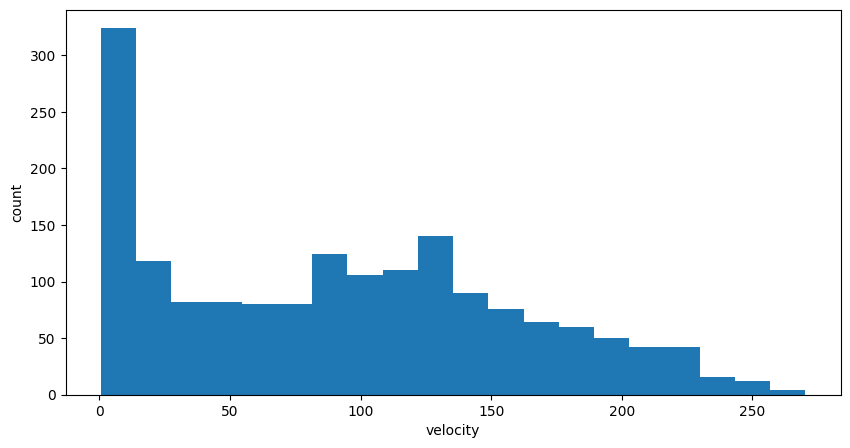

In [47]:
fig, ax = plt.subplots()
ax.hist(v['velocity'], bins =20)
ax.set(xlabel='velocity', ylabel='count');


#### Calculate the average velocity for each particle

In [ ]:
#v1=v.copy()
#dframe= would have to know number of frames which is tricky since some particles dont last through all frames

#v1['ave_velocity']= (v1.groupby('particle')['velocity'].sum()) / dframe